# Setting

In [1]:
# !pip install -q pytimekr
# !pip install -q rdkit

In [2]:
# import sys
# sys.path.append('/Volumes/KHJ/Github/hyuckjinkim/lib-python')

In [3]:
from base import gc_collect_all
from data_prepare import (
    get_holiday, reduce_mem_usage, delete_unique_columns,
    TypeController, CategoricalQuantileCalculator,
    GroupScaler, OneHotEncoder, InteractionTerm, TargetTransform,
)

In [4]:
gc_collect_all()

In [5]:
from tqdm import tqdm
tqdm.pandas()

import numpy as np
import pandas as pd
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import rc
# rc('font', family='AppleGothic')
# plt.rcParams['axes.unicode_minus'] = False

import datetime

pd.set_option('mode.chained_assignment',  None)

In [6]:
def global_assignment(dictionary):
    for k,v in dictionary.items():
        exec("globals()['{}']=dictionary['{}']".format(k,k))

In [7]:
def smape(true, pred):
    v = 2 * abs(pred - true) / (abs(pred) + abs(true))
    output = np.mean(v) * 100
    return output

In [8]:
def abline(intercept,slope):
    axes = plt.gca()
    x_vals = np.array(axes.get_xlim())
    y_vals = intercept + slope * x_vals
    plt.plot(x_vals, y_vals, linestyle='--', color='red')

<br></br>

# Configuration

In [9]:
# import os
# os.chdir('../')

In [10]:
class CFG:
    TARGET = ['MLM','HLM']
    SEGMENT = None
    SUBSET_DEPTH = 2
    
    # transform
    TARGET_TRANSFORMATION = 'identity'
    
    # kfold
    SEED = 0
    N_SPLITS = 5

<br></br>

# Data Load

In [11]:
train_df = pd.read_csv('./data/train.csv')
test_df  = pd.read_csv('./data/test.csv')

In [12]:
train_df.head()

,id,SMILES,MLM,HLM,AlogP,Molecular_Weight,Num_H_Acceptors,Num_H_Donors,Num_RotatableBonds,LogD,Molecular_PolarSurfaceArea
0,TRAIN_0000,CCOc1ccc(CNC(=O)c2cc(-c3sc(C)nc3C)n[nH]2)cc1OCC,26.010,50.680,3.259,400.495,5,2,8,3.259,117.37
1,TRAIN_0001,Cc1nc(C)c(CN2CC(C)C(=O)Nc3ccccc32)s1,29.270,50.590,2.169,301.407,2,1,2,2.172,73.47
2,TRAIN_0002,CCCN1CCN(c2nn3nnnc3c3ccccc23)CC1,5.586,80.892,1.593,297.358,5,0,3,1.585,62.45
3,TRAIN_0003,Cc1ccc(-c2ccc(-n3nc(C)c(S(=O)(=O)N4CCN(C5CCCCC...,5.710,2.000,4.771,494.652,6,0,5,3.475,92.60
4,TRAIN_0004,Cc1ccc2c(c1)N(C(=O)c1ccncc1)CC(C)O2,93.270,99.990,2.335,268.310,3,0,1,2.337,42.43


<br></br>

# EDA

In [13]:
# train_df.describe().round(2)

In [14]:
# num_features = train_df.columns[train_df.dtypes!='object'].tolist()
# for i,col in enumerate(num_features):

#     fig = plt.figure(figsize=(15,7))
#     fig.add_subplot(121)
#     sns.histplot(train_df[col],bins=20)
#     plt.grid()

#     fig.add_subplot(122)
#     sns.histplot(np.log(train_df[col]+1e-3),bins=20)
#     plt.grid()

#     plt.suptitle('[{}/{}] {}'.format(i+1,len(num_features),col))
#     plt.tight_layout()
#     plt.show()

# # -> ['Molecular_Weight','Molecular_PolarSurfaceArea']

In [15]:
# cols = ['AlogP','Molecular_Weight','Num_H_Acceptors','Num_H_Donors','Num_RotatableBonds','LogD','Molecular_PolarSurfaceArea']
# for col in cols:
#     print(col)
#     plt.figure(figsize=(15,7))
#     sns.scatterplot(x=train_df[col],y=train_df['HLM'])
#     plt.grid()
#     plt.show()

In [16]:
# cols = ['Num_H_Acceptors','Num_H_Donors','Num_RotatableBonds']
# for col in cols:
#     print(col)
#     plt.figure(figsize=(15,7))
#     sns.boxplot(x=train_df[col],y=train_df.MLM)
#     plt.show()

In [17]:
# train_df.nunique()

In [18]:
# lists = sorted(train_df['Num_H_Acceptors'].unique())
# for v in lists:
#     print('########',v)
#     d = train_df[train_df['Num_H_Acceptors']==v]
    
#     cols = ['AlogP','Molecular_Weight','Num_H_Acceptors','Num_H_Donors','Num_RotatableBonds','LogD','Molecular_PolarSurfaceArea']
#     for col in cols:
#         print(col)
#         plt.figure(figsize=(15,7))
#         sns.scatterplot(x=d[col],y=d['HLM'])
#         plt.grid()
#         plt.show()

<br></br>

# Data Preprocess

In [19]:
for col in ['Molecular_Weight','Molecular_PolarSurfaceArea']:
    train_df[col] = np.log(train_df[col])
    test_df [col] = np.log(test_df [col])

- [Dacon](https://dacon.io/competitions/official/236127/talkboard/409051?page=1&dtype=recent)에 따르면 100이 넘는 값도 나올 수 있음

In [20]:
# targets = ['MLM','HLM']
# for t in targets:
#     train_df[t] = [0 if x<0 else
#                    100 if x>100 else
#                    x for x in train_df[t]]

<br>

In [21]:
from rdkit import DataStructs
from rdkit.Chem import PandasTools, AllChem

In [22]:
# 화학구조 이미지 생성
PandasTools.AddMoleculeColumnToFrame(train_df,'SMILES','Molecule')
PandasTools.AddMoleculeColumnToFrame(test_df ,'SMILES','Molecule')

In [23]:
# Molecule to MorganFingerprint
def mol2fp(mol):
    #radius, nBits = 6, 4096
    radius, nBits = 3, 4096
    fp = AllChem.GetHashedMorganFingerprint(mol, radius=radius, nBits=nBits)
    ar = np.zeros((1,), dtype=np.int8)
    DataStructs.ConvertToNumpyArray(fp, ar)
    return ar

In [24]:
# FPs column 추가
train_df["FPs"] = train_df.Molecule.apply(mol2fp)
test_df ["FPs"] = test_df .Molecule.apply(mol2fp)

In [25]:
from sklearn.feature_selection import VarianceThreshold

In [26]:
feature_select = VarianceThreshold(threshold=0.05)

# 일부사용
tr_fps_selected = feature_select.fit_transform(np.stack(train_df['FPs']))
te_fps_selected = feature_select.transform(np.stack(test_df['FPs']))

# # 전체사용
# tr_fps_selected = np.stack(train_df['FPs'])
# te_fps_selected = np.stack(test_df ['FPs'])

fps_names = ['fps'+str(i+1) for i in range(tr_fps_selected.shape[1])]
print(len(fps_names))

train_df = pd.concat([
    train_df.drop('FPs',axis=1),
    pd.DataFrame(tr_fps_selected,columns=fps_names),
],axis=1)

test_df = pd.concat([
    test_df.drop('FPs',axis=1),
    pd.DataFrame(te_fps_selected,columns=fps_names),
],axis=1)

222


In [27]:
# sns.boxplot(train_df[fps_names].std()**2)

In [28]:
# sorted_fps_names = train_df[fps_names].std().sort_values(ascending=False).index.tolist()
# sorted_fps_names = sorted_fps_names[:5]

# # sorted_fps_names = train_df[fps_names].nunique().sort_values(ascending=False).index.tolist()
# # sorted_fps_names = sorted_fps_names[:5]

# for i,col in enumerate(sorted_fps_names):
#     corr_mlm = train_df[[col,'MLM']].corr().values[0,1]
#     corr_hlm = train_df[[col,'HLM']].corr().values[0,1]
    
#     fig = plt.figure(figsize=(15,7))
#     fig.add_subplot(121)
#     sns.scatterplot(x=train_df[col],y=train_df['MLM'])
#     plt.grid()
#     plt.title('[MLM] Correlation: {:.4f}'.format(corr_mlm))
#     fig.add_subplot(122)
#     sns.scatterplot(x=train_df[col],y=train_df['HLM'])
#     plt.grid()
#     plt.title('[HLM] Correlation: {:.4f}'.format(corr_hlm))
#     plt.suptitle('[{}/{}] {}'.format(i+1,len(sorted_fps_names),col))
#     plt.tight_layout()
#     plt.show()

In [29]:
# col = sorted_fps_names[0]

# plt.figure(figsize=(15,7))
# sns.regplot(x=train_df[col],y=train_df['MLM'])
# plt.grid()
# plt.show()

In [30]:
# train_df['fps_raw_avg'] = np.mean(train_df[fps_names].values,axis=1)
# test_df ['fps_raw_avg'] = np.mean(test_df [fps_names].values,axis=1)

In [31]:
# for col in ['MLM','HLM']:
#     plt.figure(figsize=(15,7))
#     sns.scatterplot(x=train_df['fps_raw_avg'],y=train_df[col])
#     plt.grid()
#     plt.title(col)
#     plt.show()

In [32]:
# fps_dummy_names = []
# for col in fps_names:
#     train_df[f'{col}_dmy'] = np.where(train_df[col]==0,0,1)
#     test_df [f'{col}_dmy'] = np.where(test_df [col]==0,0,1)
#     fps_dummy_names.append(f'{col}_dmy')

In [33]:
# train_df['fps_dummy_sum'] = np.sum(train_df[fps_dummy_names].values,axis=1)
# test_df ['fps_dummy_sum'] = np.sum(test_df [fps_dummy_names].values,axis=1)

In [34]:
# train_df.drop(fps_names,axis=1,inplace=True)
# test_df .drop(fps_names,axis=1,inplace=True)

In [35]:
# 사용할 column만 추출
unuse_features = ['id','SMILES','Molecule']
num_features = [col for col in train_df.columns if col not in unuse_features+CFG.TARGET]

train_df.drop(unuse_features,axis=1,inplace=True)
test_df .drop(unuse_features,axis=1,inplace=True)

In [36]:
train_df.shape

(3498, 231)

In [37]:
train_df.head()

,MLM,HLM,AlogP,Molecular_Weight,Num_H_Acceptors,Num_H_Donors,Num_RotatableBonds,LogD,Molecular_PolarSurfaceArea,fps1,fps2,fps3,fps4,fps5,fps6,fps7,fps8,fps9,fps10,fps11,fps12,fps13,fps14,fps15,fps16,fps17,fps18,fps19,fps20,fps21,fps22,fps23,fps24,fps25,fps26,fps27,fps28,fps29,fps30,fps31,fps32,fps33,fps34,fps35,fps36,fps37,fps38,fps39,fps40,fps41,fps42,fps43,fps44,fps45,fps46,fps47,fps48,fps49,fps50,fps51,fps52,fps53,fps54,fps55,fps56,fps57,fps58,fps59,fps60,fps61,fps62,fps63,fps64,fps65,fps66,fps67,fps68,fps69,fps70,fps71,fps72,fps73,fps74,fps75,fps76,fps77,fps78,fps79,fps80,fps81,fps82,fps83,fps84,fps85,fps86,fps87,fps88,fps89,fps90,fps91,fps92,fps93,fps94,fps95,fps96,fps97,fps98,fps99,fps100,fps101,fps102,fps103,fps104,fps105,fps106,fps107,fps108,fps109,fps110,fps111,fps112,fps113,fps114,fps115,fps116,fps117,fps118,fps119,fps120,fps121,fps122,fps123,fps124,fps125,fps126,fps127,fps128,fps129,fps130,fps131,fps132,fps133,fps134,fps135,fps136,fps137,fps138,fps139,fps140,fps141,fps142,fps143,fps144,fps145,fps146,fps147,fps148,fps149,fps150,fps151,fps152,fps153,fps154,fps155,fps156,fps157,fps158,fps159,fps160,fps161,fps162,fps163,fps164,fps165,fps166,fps167,fps168,fps169,fps170,fps171,fps172,fps173,fps174,fps175,fps176,fps177,fps178,fps179,fps180,fps181,fps182,fps183,fps184,fps185,fps186,fps187,fps188,fps189,fps190,fps191,fps192,fps193,fps194,fps195,fps196,fps197,fps198,fps199,fps200,fps201,fps202,fps203,fps204,fps205,fps206,fps207,fps208,fps209,fps210,fps211,fps212,fps213,fps214,fps215,fps216,fps217,fps218,fps219,fps220,fps221,fps222
0,26.010,50.680,3.259,5.992701,5,2,8,3.259,4.765331,0,0,0,0,0,0,1,1,0,0,1,0,1,1,0,0,0,0,0,0,0,0,0,0,0,2,0,0,0,0,0,0,0,0,0,0,1,2,0,0,0,0,0,0,0,0,2,0,0,2,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,0,0,0,0,0,0,0,0,0,0,0,8,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,2,0,0,0,0,0,0,1,3,0,0,0,0,0,1,0,2,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,4,0,0,2,0,2,0,0,0,0,0,0,0,0,0,0,0,2,0,0,0,0,0,1,0,0,0,0,0,0,0,2,0,0,2,1,0,0,0,0,0,0,0,0,0,0,4,0,0,0,0,1,0
1,29.270,50.590,2.169,5.708462,2,1,2,2.172,4.296877,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,6,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,1,0,1,0,3,0,0,1,0,0,0,0,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,0,0,2,0,0,0,0,0,0,0,0,0,0,0,4,0,0,0,0,0,0
2,5.586,80.892,1.593,5.694937,5,0,3,1.585,4.134366,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,2,0,4,0,0,0,4,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,2,0,0,0,2,2,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,4,3,0,0,0,1,0,0,0,0,0,0,0,2,0,0,0,1,0,0,0,0,0,0,0,2,0,0,2,0,0,0,0,0,0,0,0,0,0,2,0,0,1,0,0,0,0,0,0,0,0,4,0,0,0,0,0,0
3,5.710,2.000,4.771,6.203854,6,0,5,3.475,4.528289,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,2,0,0,0,0,0,0,1,0,3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,3,0,0,0,0,0,0,0,0,1,0,0,2,0,0,0,0,0,0,0,0,0,0,0,0,2,0,0,7,0,0,0,4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,2,0,9,3,0,1,0,3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,0,0,0,0,0,0,0,0,0,0,0,0,4,0,0,6,0,1,0,0,0,0,0,0,0,0,0,6,0,0,0,0,0,0
4,93.270,99.990,2.335,5.592143,3,0,1,2.337,3.747856,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,0,0,0,0,0,0,0,0,1,1,0,0,0,0,4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,1,1,0,1,0,2,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,1,0,0,4,0

In [38]:
test_df.head()

,AlogP,Molecular_Weight,Num_H_Acceptors,Num_H_Donors,Num_RotatableBonds,LogD,Molecular_PolarSurfaceArea,fps1,fps2,fps3,fps4,fps5,fps6,fps7,fps8,fps9,fps10,fps11,fps12,fps13,fps14,fps15,fps16,fps17,fps18,fps19,fps20,fps21,fps22,fps23,fps24,fps25,fps26,fps27,fps28,fps29,fps30,fps31,fps32,fps33,fps34,fps35,fps36,fps37,fps38,fps39,fps40,fps41,fps42,fps43,fps44,fps45,fps46,fps47,fps48,fps49,fps50,fps51,fps52,fps53,fps54,fps55,fps56,fps57,fps58,fps59,fps60,fps61,fps62,fps63,fps64,fps65,fps66,fps67,fps68,fps69,fps70,fps71,fps72,fps73,fps74,fps75,fps76,fps77,fps78,fps79,fps80,fps81,fps82,fps83,fps84,fps85,fps86,fps87,fps88,fps89,fps90,fps91,fps92,fps93,fps94,fps95,fps96,fps97,fps98,fps99,fps100,fps101,fps102,fps103,fps104,fps105,fps106,fps107,fps108,fps109,fps110,fps111,fps112,fps113,fps114,fps115,fps116,fps117,fps118,fps119,fps120,fps121,fps122,fps123,fps124,fps125,fps126,fps127,fps128,fps129,fps130,fps131,fps132,fps133,fps134,fps135,fps136,fps137,fps138,fps139,fps140,fps141,fps142,fps143,fps144,fps145,fps146,fps147,fps148,fps149,fps150,fps151,fps152,fps153,fps154,fps155,fps156,fps157,fps158,fps159,fps160,fps161,fps162,fps163,fps164,fps165,fps166,fps167,fps168,fps169,fps170,fps171,fps172,fps173,fps174,fps175,fps176,fps177,fps178,fps179,fps180,fps181,fps182,fps183,fps184,fps185,fps186,fps187,fps188,fps189,fps190,fps191,fps192,fps193,fps194,fps195,fps196,fps197,fps198,fps199,fps200,fps201,fps202,fps203,fps204,fps205,fps206,fps207,fps208,fps209,fps210,fps211,fps212,fps213,fps214,fps215,fps216,fps217,fps218,fps219,fps220,fps221,fps222
0,2.641,5.890276,4,2,7,2.635,4.530016,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,3,0,0,0,2,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,1,1,0,0,3,0,0,1,0,0,0,2,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,3,2,0,1,0,2,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,2,0,0,0,0,0,0,0,0,0,0,1,5,0,0,0,0,0,0
1,0.585,5.914581,5,0,3,0.585,4.224056,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,1,0,0,0,1,0,0,2,0,1,0,0,0,0,0,0,0,1,1,0,2,0,0,0,0,2,0,0,3,0,0,0,0,0,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,4,0,0,0,2,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,6,2,2,0,0,1,1,0,0,1,0,0,0,2,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,0,0,0,0,0,0,1,0,0,0,0,7,0,0,0,1,0,1
2,4.276,5.850517,4,4,5,4.290,4.531093,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,2,0,4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,7,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,2,0,0,1,0,1,0,0,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,2,0,1,4,1,0,0,0,0,1,0,0,0,0,0,9,0,0,0,0,0,0
3,1.795,5.844582,5,0,2,1.795,4.397038,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,4,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,4,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,5,0,0,0,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,0,1,0,1,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,1,0,0,1,0,0,0,2,0,0,0,0,1,0,0,0,0,0,0,3,3,0,0,0,0,0,0,0,0,0,0,0,2,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,0,0,0,0,0,0,0,0,0,0,1,9,0,0,0,0,0,0
4,1.219,5.867651,4,0,2,0.169,4.113330,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,6,0,0,0,4,0,0,0,2,0,0,0,0,0,1,0,0,0,0,1,1,0,1,0,0,0,0,0,0,0,0,0,0,0,2,1,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,2,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,4,4,0,0,0,3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,2,0,0,1,0,0,0,0,0,0,0,0,4,0,0,0,0,0,1


<br>

## Imputation

In [39]:
def check_null(data):
    d = data.copy()

    null_info = d\
        .isnull().sum()\
        .reset_index()\
        .rename(columns={'index':'feature',0:'null_cnt'})

    null_info = null_info[null_info['null_cnt']!=0]
    null_info['null_percentage'] = 100 * null_info['null_cnt'] / len(train_df)
    null_info = null_info.sort_values('null_cnt',ascending=False).round(2)
    
    return null_info

In [40]:
check_null(train_df)

,feature,null_cnt,null_percentage
2,AlogP,2,0.06


In [41]:
# Imputation
tr_null_loc = train_df.AlogP.isnull()
te_null_loc = test_df .AlogP.isnull()

train_df.AlogP[tr_null_loc] = train_df.LogD[tr_null_loc]
test_df .AlogP[te_null_loc] = test_df .LogD[te_null_loc]

In [42]:
check_null(train_df)

,feature,null_cnt,null_percentage


<br>

## Numerical Quantile Group

In [43]:
from sklearn.preprocessing import LabelEncoder

In [44]:
cols = [col for col in num_features if col.find('fps')<0]
quantile_list = np.arange(0.0,1.1,0.1)
display(quantile_list)

for col in cols:
    col_name = '{}_quantile{}_grp'.format(col,len(quantile_list))
    quantile_values = train_df[col].quantile(quantile_list).values
    quantile_values[0] = -np.inf
    quantile_values[-1] = np.inf

    try:
        le = LabelEncoder()
        tr_grp = pd.cut(train_df[col],quantile_values)
        te_grp = pd.cut(test_df [col],quantile_values)
        train_df[col_name] = le.fit_transform(tr_grp)
        test_df [col_name] = le.transform(te_grp)
        if (train_df[col_name].isnull().sum()>0) | (test_df[col_name].isnull().sum()>0):
            raise ValueError('NaN exists')
    except:
        print('Failed: {}'.format(col))

array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ])

Failed: Num_H_Acceptors
Failed: Num_H_Donors
Failed: Num_RotatableBonds


<br>

## Target Transformation

(1) simple transformation (identity / log / sqrt)

In [45]:
target_transform = TargetTransform(func=CFG.TARGET_TRANSFORMATION)
train_df[CFG.TARGET] = target_transform.fit_transform(
    target=train_df[CFG.TARGET],
)

In [46]:
inverse_transform = target_transform.inverse_transform

In [47]:
train_df.head()

,MLM,HLM,AlogP,Molecular_Weight,Num_H_Acceptors,Num_H_Donors,Num_RotatableBonds,LogD,Molecular_PolarSurfaceArea,fps1,fps2,fps3,fps4,fps5,fps6,fps7,fps8,fps9,fps10,fps11,fps12,fps13,fps14,fps15,fps16,fps17,fps18,fps19,fps20,fps21,fps22,fps23,fps24,fps25,fps26,fps27,fps28,fps29,fps30,fps31,fps32,fps33,fps34,fps35,fps36,fps37,fps38,fps39,fps40,fps41,fps42,fps43,fps44,fps45,fps46,fps47,fps48,fps49,fps50,fps51,fps52,fps53,fps54,fps55,fps56,fps57,fps58,fps59,fps60,fps61,fps62,fps63,fps64,fps65,fps66,fps67,fps68,fps69,fps70,fps71,fps72,fps73,fps74,fps75,fps76,fps77,fps78,fps79,fps80,fps81,fps82,fps83,fps84,fps85,fps86,fps87,fps88,fps89,fps90,fps91,fps92,fps93,fps94,fps95,fps96,fps97,fps98,fps99,fps100,fps101,fps102,fps103,fps104,fps105,fps106,fps107,fps108,fps109,fps110,fps111,fps112,fps113,fps114,fps115,fps116,fps117,fps118,fps119,fps120,fps121,fps122,fps123,fps124,fps125,fps126,fps127,fps128,fps129,fps130,fps131,fps132,fps133,fps134,fps135,fps136,fps137,fps138,fps139,fps140,fps141,fps142,fps143,fps144,fps145,fps146,fps147,fps148,fps149,fps150,fps151,fps152,fps153,fps154,fps155,fps156,fps157,fps158,fps159,fps160,fps161,fps162,fps163,fps164,fps165,fps166,fps167,fps168,fps169,fps170,fps171,fps172,fps173,fps174,fps175,fps176,fps177,fps178,fps179,fps180,fps181,fps182,fps183,fps184,fps185,fps186,fps187,fps188,fps189,fps190,fps191,fps192,fps193,fps194,fps195,fps196,fps197,fps198,fps199,fps200,fps201,fps202,fps203,fps204,fps205,fps206,fps207,fps208,fps209,fps210,fps211,fps212,fps213,fps214,fps215,fps216,fps217,fps218,fps219,fps220,fps221,fps222,AlogP_quantile11_grp,Molecular_Weight_quantile11_grp,LogD_quantile11_grp,Molecular_PolarSurfaceArea_quantile11_grp
0,26.010,50.680,3.259,5.992701,5,2,8,3.259,4.765331,0,0,0,0,0,0,1,1,0,0,1,0,1,1,0,0,0,0,0,0,0,0,0,0,0,2,0,0,0,0,0,0,0,0,0,0,1,2,0,0,0,0,0,0,0,0,2,0,0,2,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,0,0,0,0,0,0,0,0,0,0,0,8,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,2,0,0,0,0,0,0,1,3,0,0,0,0,0,1,0,2,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,4,0,0,2,0,2,0,0,0,0,0,0,0,0,0,0,0,2,0,0,0,0,0,1,0,0,0,0,0,0,0,2,0,0,2,1,0,0,0,0,0,0,0,0,0,0,4,0,0,0,0,1,0,5,7,6,9
1,29.270,50.590,2.169,5.708462,2,1,2,2.172,4.296877,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,6,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,1,0,1,0,3,0,0,1,0,0,0,0,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,0,0,2,0,0,0,0,0,0,0,0,0,0,0,4,0,0,0,0,0,0,3,2,3,4
2,5.586,80.892,1.593,5.694937,5,0,3,1.585,4.134366,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,2,0,4,0,0,0,4,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,2,0,0,0,2,2,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,4,3,0,0,0,1,0,0,0,0,0,0,0,2,0,0,0,1,0,0,0,0,0,0,0,2,0,0,2,0,0,0,0,0,0,0,0,0,0,2,0,0,1,0,0,0,0,0,0,0,0,4,0,0,0,0,0,0,2,2,2,2
3,5.710,2.000,4.771,6.203854,6,0,5,3.475,4.528289,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,2,0,0,0,0,0,0,1,0,3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,3,0,0,0,0,0,0,0,0,1,0,0,2,0,0,0,0,0,0,0,0,0,0,0,0,2,0,0,7,0,0,0,4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,2,0,9,3,0,1,0,3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,0,0,0,0,0,0,0,0,0,0,0,0,4,0,0,6,0,1,0,0,0,0,0,0,0,0,0,6,0,0,0,0,0,0,9,9,6,6
4,93.270,99.990,2.335,5.592143,3,0,1,2.337,3.747856,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,0,0,0,0,0,0,0,0,1,1,0,0,0,0,4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,

(2) boxcox transformation → nan발생함

In [48]:
# from scipy.special import boxcox, inv_boxcox

# def boxcox_transform(x,lam=0.25):
#     return boxcox(x,lam)

# def inverse_boxcox_transform(x,lam=0.25):
#     return inv_boxcox(x,lam)

In [49]:
# inverse_transform = inverse_boxcox_transform

In [50]:
# y = train_df['HLM'].copy()
# y = boxcox_transform(y,0.45)

# print(y.isnull().sum())

# plt.figure(figsize=(15,7))
# plt.hist(y,bins=50)
# plt.grid()
# plt.show()

In [51]:
# for col in CFG.TARGET:
#     train_df[col] = boxcox_transform(train_df[col])

In [52]:
# train_df[CFG.TARGET].isnull().sum()

In [53]:
# inverse_transform(train_df[CFG.TARGET]).isnull().sum()

(3) quantile transformer

In [54]:
# from sklearn.preprocessing import QuantileTransformer

# scaler = QuantileTransformer()
# scaled = scaler.fit_transform(train_df[CFG.TARGET])

In [55]:
# inverse_transform = scaler.inverse_transform

In [56]:
# # asis
# fig = plt.figure(figsize=(15,7))
# fig.add_subplot(121)
# sns.histplot(train_df['MLM'],bins=20)
# plt.title('MLM')
# plt.grid()
# fig.add_subplot(122)
# sns.histplot(train_df['HLM'],bins=20)
# plt.title('HLM')
# plt.grid()
# plt.suptitle('Asis',fontsize=20)
# plt.tight_layout()
# plt.show()

# fig = plt.figure(figsize=(15,7))
# fig.add_subplot(121)
# sns.histplot(scaled[:,0],bins=20)
# plt.title('MLM')
# plt.grid()
# fig.add_subplot(122)
# sns.histplot(scaled[:,1],bins=20)
# plt.title('HLM')
# plt.grid()
# plt.suptitle('Tobe',fontsize=20)
# plt.tight_layout()
# plt.show()

In [57]:
# train_df[CFG.TARGET] = scaled

In [58]:
# train_df.head()

(4) sigmoid → nan발생함

In [59]:
# import warnings
# warnings.filterwarnings("ignore")

# from sklearn.preprocessing import MinMaxScaler

# class SigmoidTransformer:
#     def __init__(self):
#         self.minmax_scaler = MinMaxScaler(feature_range=(-5,5))
        
#     def _sigmoid(self,x):
#         return 1 / (1+np.exp(-x))
    
#     def _inv_sigmoid(self,x):
#         return -np.log(1/x-1)

#     def fit(self,x):
#         self.shape = np.array(x).shape
#         y = np.array(x).reshape(-1,self.shape[1])
#         self.minmax_scaler.fit(y)
    
#     def transform(self,x):
#         y = np.array(x).reshape(-1,self.shape[1])
#         y = self.minmax_scaler.transform(x)
#         y = y.reshape(-1,self.shape[1])
#         y = self._sigmoid(y)
#         return y
    
#     def fit_transform(self,x):
#         self.fit(x)
#         return self.transform(x)
    
#     def inverse_transform(self,x):
#         y = np.array(x)
#         y = self._inv_sigmoid(y)
#         y = np.array(y).reshape(-1,self.shape[1])
#         y = self.minmax_scaler.inverse_transform(y)
#         return y

In [60]:
# scaler = SigmoidTransformer()
# scaled = scaler.fit_transform(train_df[CFG.TARGET])

In [61]:
# inverse_transform = scaler.inverse_transform

In [62]:
# # asis
# fig = plt.figure(figsize=(15,7))
# fig.add_subplot(121)
# sns.histplot(train_df['MLM'],bins=20)
# plt.title('MLM')
# plt.grid()
# fig.add_subplot(122)
# sns.histplot(train_df['HLM'],bins=20)
# plt.title('HLM')
# plt.grid()
# plt.suptitle('Asis',fontsize=20)
# plt.tight_layout()
# plt.show()

# fig = plt.figure(figsize=(15,7))
# fig.add_subplot(121)
# sns.histplot(scaled[:,0],bins=20)
# plt.title('MLM')
# plt.grid()
# fig.add_subplot(122)
# sns.histplot(scaled[:,1],bins=20)
# plt.title('HLM')
# plt.grid()
# plt.suptitle('Tobe',fontsize=20)
# plt.tight_layout()
# plt.show()

In [63]:
# train_df[CFG.TARGET] = scaled

(5) pca transform
- 참조 : [Kaggle](https://www.kaggle.com/code/xiafire/lb-t15-msci-multiome-catboostregressor)

In [64]:
# from sklearn.decomposition import PCA, TruncatedSVD

In [65]:
# train_targets = train_df[CFG.TARGET]

# pca_target = TruncatedSVD(n_components=2, random_state=CFG.SEED)
# train_targets = pca_target.fit_transform(train_targets)

# train_df[CFG.TARGET] = train_targets

In [66]:
# inverse_transform = pca_target.inverse_transform

In [67]:
# train_df[CFG.TARGET]@pca_target.components_

(check)

In [68]:
train_df[CFG.TARGET].head()

,MLM,HLM
0,26.010,50.680
1,29.270,50.590
2,5.586,80.892
3,5.710,2.000
4,93.270,99.990


In [69]:
train_df[CFG.TARGET].isnull().sum()

MLM    0
HLM    0
dtype: int64

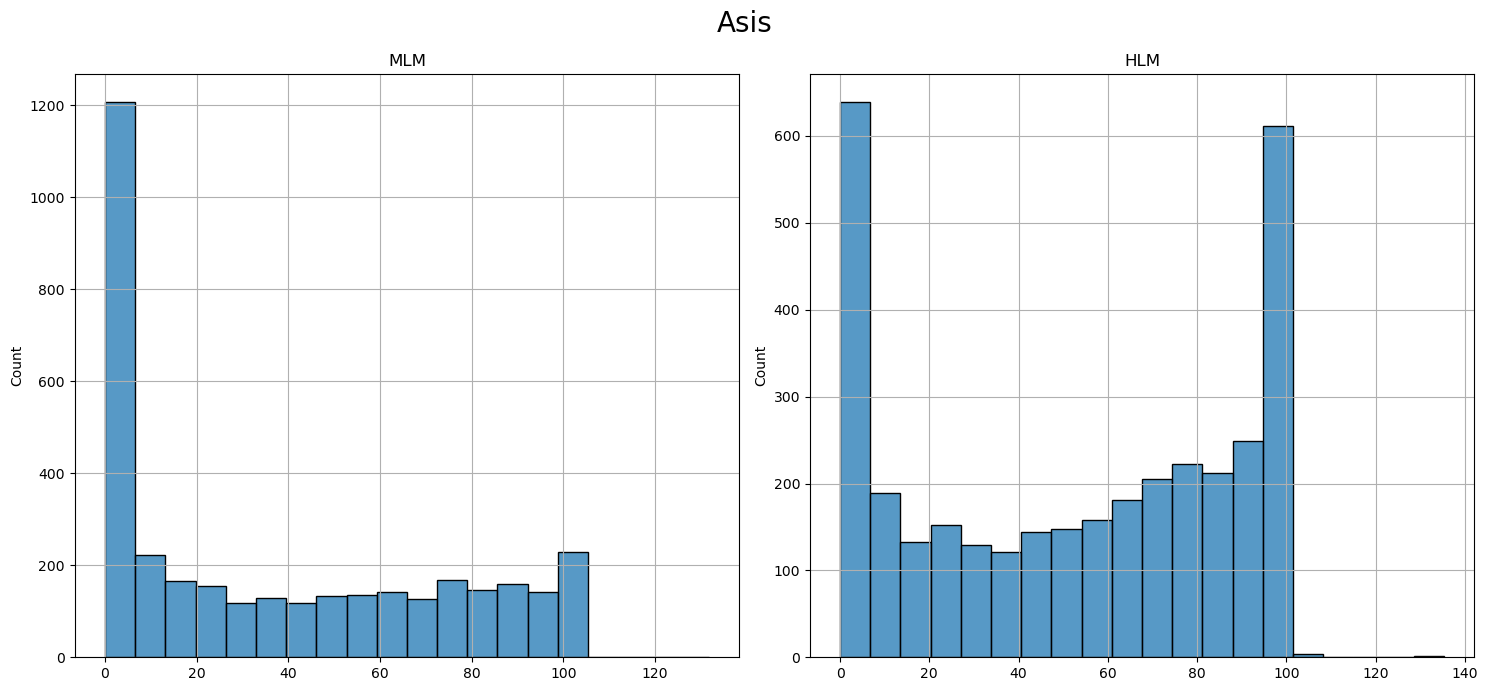

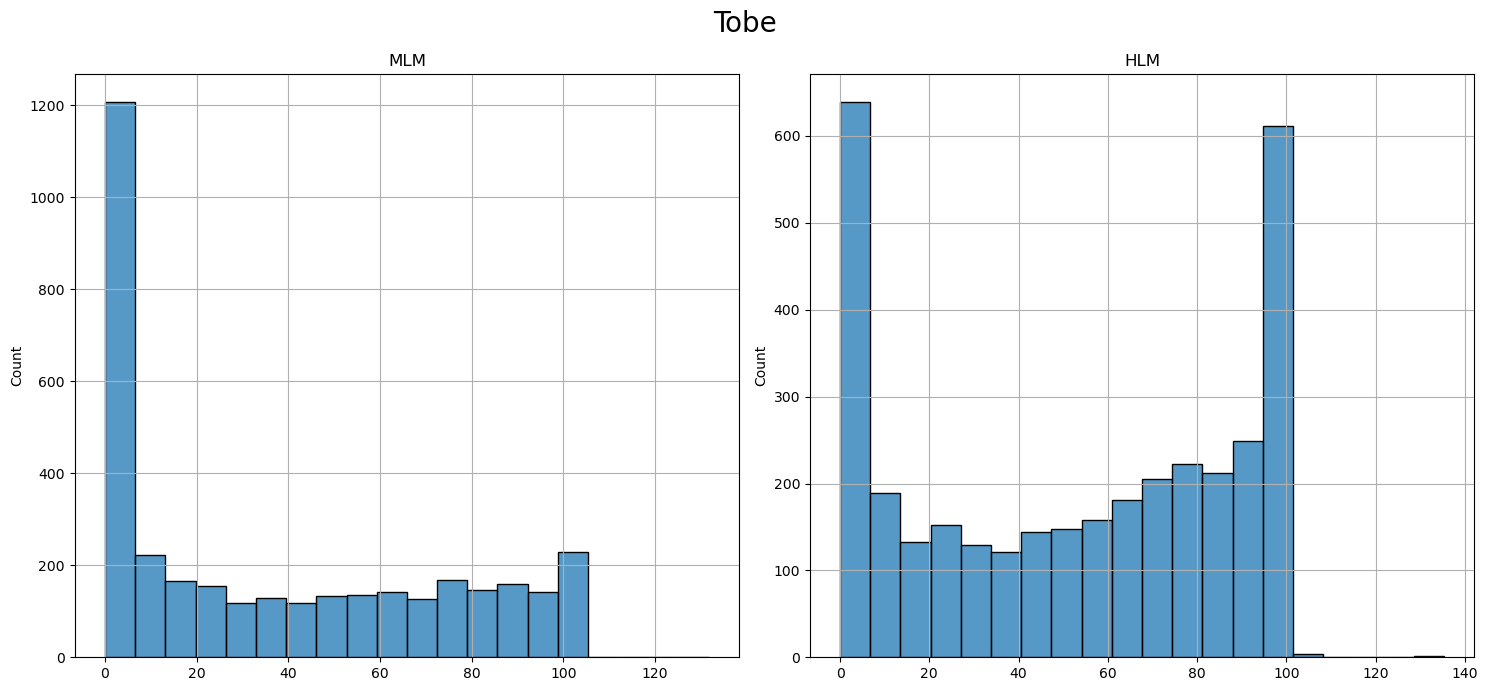

In [70]:
# Asis
ys = np.array(train_df[CFG.TARGET])
ys = inverse_transform(ys)

fig = plt.figure(figsize=(15,7))
fig.add_subplot(121)
sns.histplot(ys[:,0],bins=20)
plt.title('MLM')
plt.grid()
fig.add_subplot(122)
sns.histplot(ys[:,1],bins=20)
plt.title('HLM')
plt.grid()
plt.suptitle('Asis',fontsize=20)
plt.tight_layout()
plt.show()

# Tobe
ys = np.array(train_df[CFG.TARGET])

fig = plt.figure(figsize=(15,7))
fig.add_subplot(121)
sns.histplot(ys[:,0],bins=20)
plt.title('MLM')
plt.grid()
fig.add_subplot(122)
sns.histplot(ys[:,1],bins=20)
plt.title('HLM')
plt.grid()
plt.suptitle('Tobe',fontsize=20)
plt.tight_layout()
plt.show()

<br>

## Interaction Term

In [71]:
num_features = train_df.columns.difference(CFG.TARGET)
len(num_features)

233

In [72]:
# interaction_maker = InteractionTerm()
# interaction_maker.fit(
#     data=train_df,
#     num_features=num_features,
#     corr_cutoff=0.9,
# )
# train_df = interaction_maker.transform(train_df)
# test_df  = interaction_maker.transform(test_df)

In [73]:
# train_df.shape

In [74]:
t = 'HLM'

interaction_cols = [col for col in train_df.columns if col.find('*')>=0]
len(interaction_cols)

corr_list = []
for col in tqdm(interaction_cols):
    corr = train_df[[col,t]].corr().values[0,1]
    corr_list.append([col,np.abs(corr)])
    
corr_df = pd.DataFrame(corr_list,columns=['feature','abs_correlation'])\
    .sort_values('abs_correlation',ascending=False)

0it [00:00, ?it/s]


In [75]:
for col,corr in corr_df.values[:5]:
    plt.figure(figsize=(15,7))
    sns.scatterplot(x=train_df[col],y=train_df[t])
    plt.grid()
    plt.title('{}: {:.4f}'.format(col,corr))
    plt.show()

<br>

## Categorical Taget Quantile

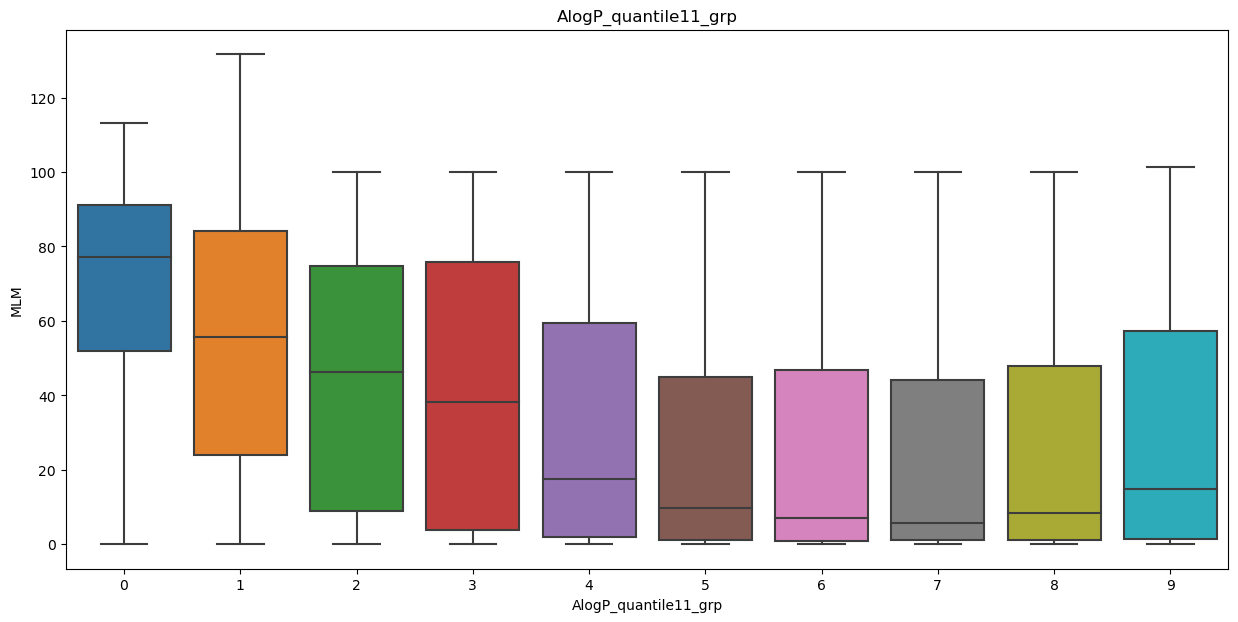

0 []


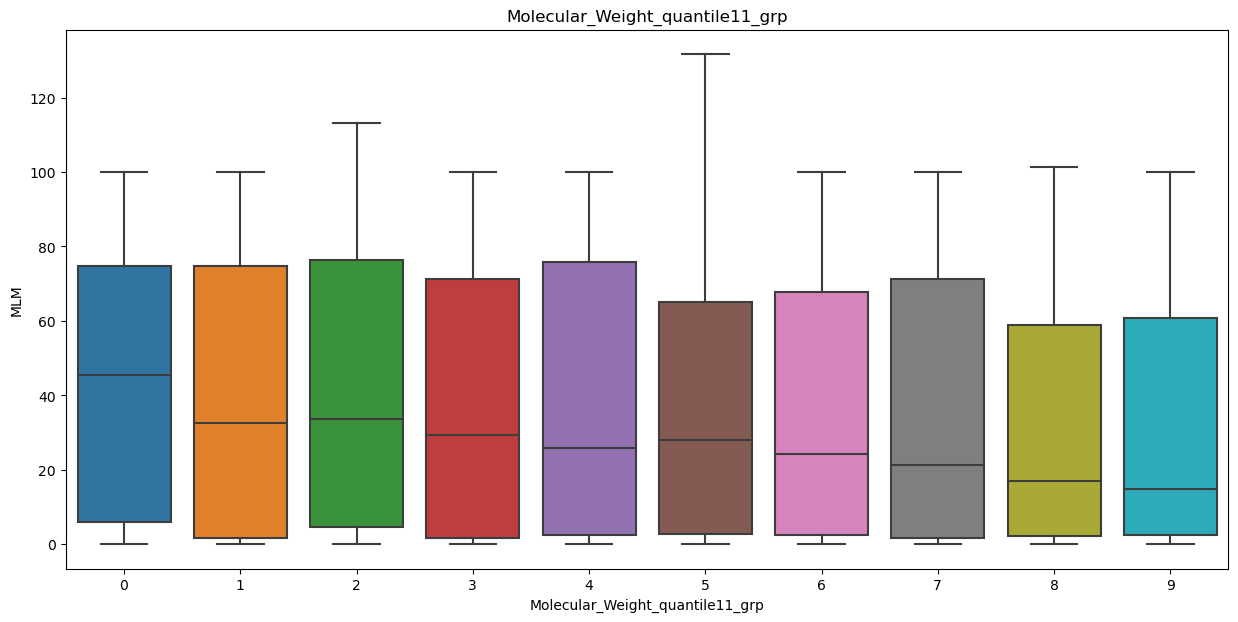

0 []


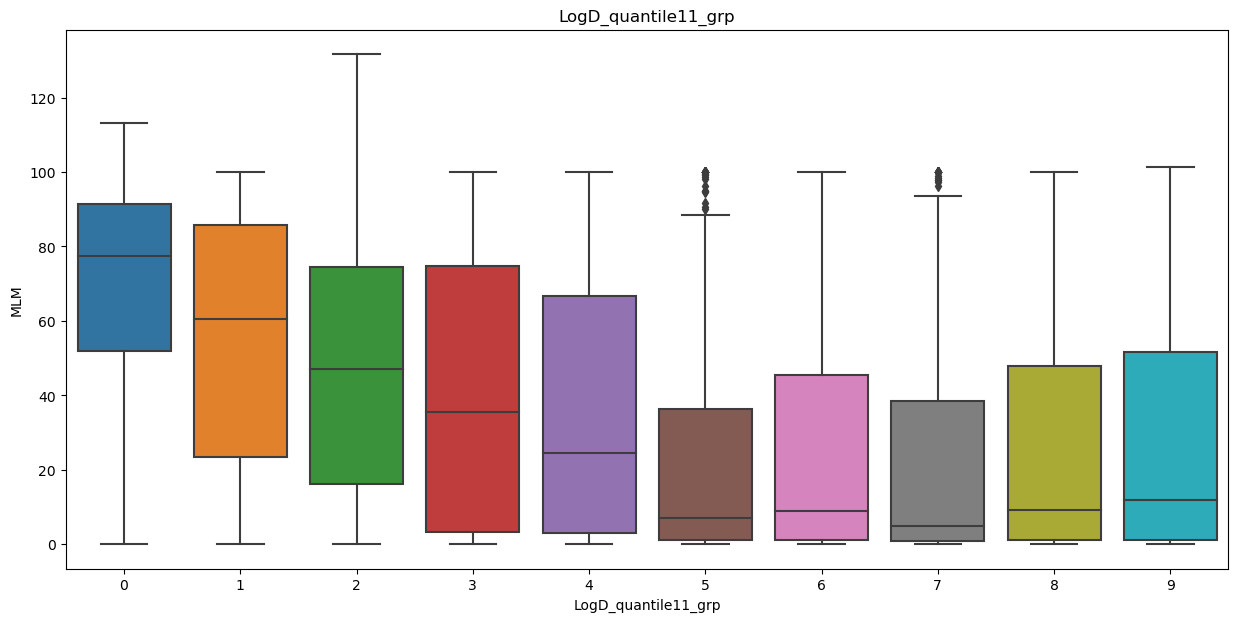

0 []


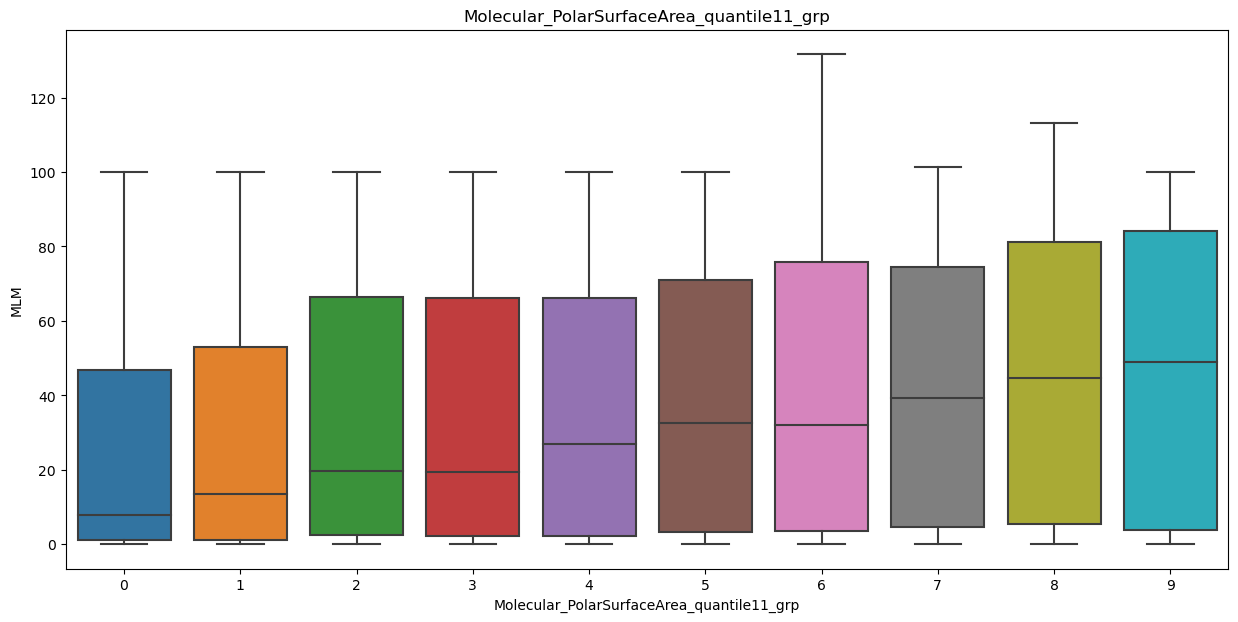

0 []


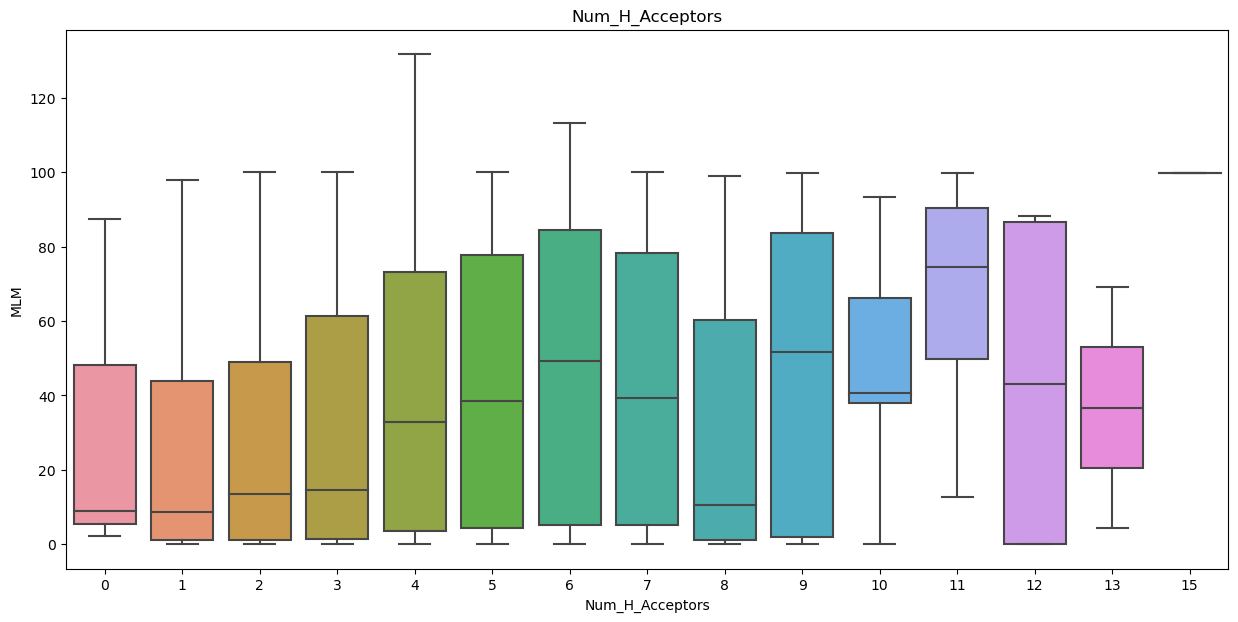

0 []


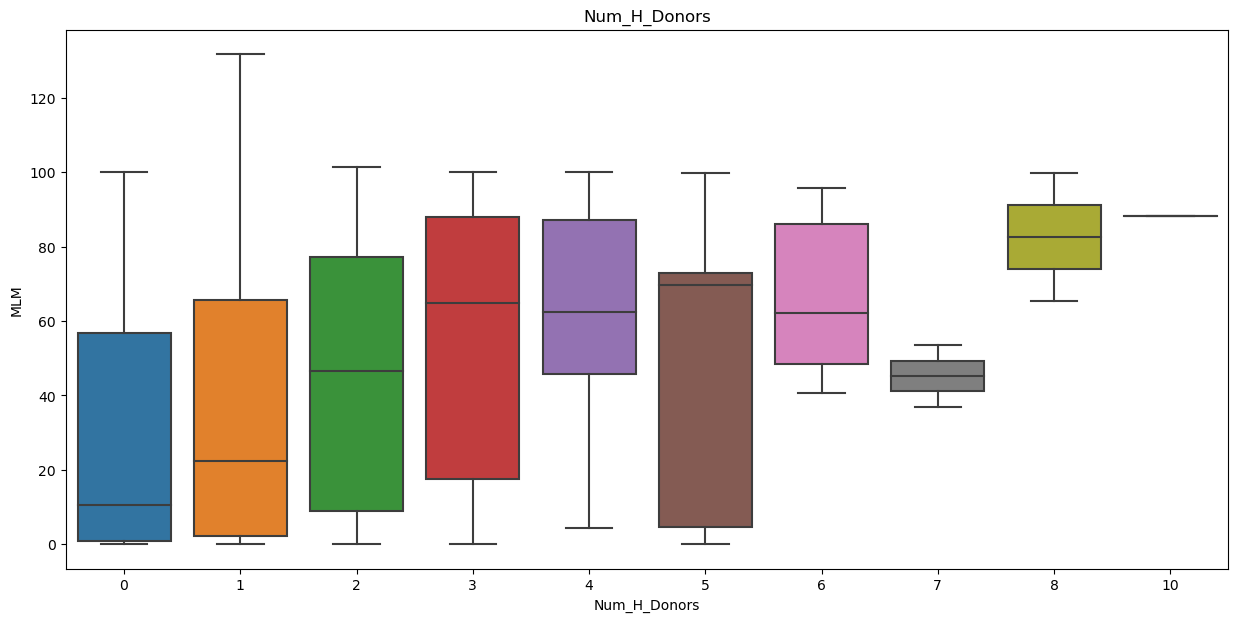

0 []


In [76]:
num_quantile_grp_features = [col for col in train_df.columns if (col.find('_quantile')>=0) & (col.find('_grp')>=0)]
cat_features = num_quantile_grp_features + ['Num_H_Acceptors','Num_H_Donors'] #,'Num_RotatableBonds']

for f in cat_features:
    plt.figure(figsize=(15,7))
    sns.boxplot(x=train_df[f],y=train_df['MLM'])
    plt.title(f)
    plt.show()
    only_test = list(set(test_df[f].unique())-set(train_df[f].unique()))
    print(len(only_test),only_test)

In [77]:
train_df[cat_features] = train_df[cat_features].astype(str)
test_df [cat_features] = test_df [cat_features].astype(str)

In [78]:
for target in CFG.TARGET:
    calculator = CategoricalQuantileCalculator()
    calculator.fit(
        data=train_df,
        test_data=test_df,
        target_feature=target,
        cat_features=cat_features,
        subset_depth=CFG.SUBSET_DEPTH,
    )
    train_df = calculator.transform(train_df,prefix=f'{target}_')
    test_df  = calculator.transform(test_df ,prefix=f'{target}_')

> Get quantiles of target by categorical features (depth=2)


Subset: Molecular_PolarSurfaceArea_quantile11_grp + Num_H_Acceptors: 100%|██████████| 21/21 [00:01<00:00, 15.01it/s]                


> Get quantiles of target by categorical features (depth=2)


Subset: Molecular_PolarSurfaceArea_quantile11_grp + Num_H_Acceptors: 100%|██████████| 21/21 [00:01<00:00, 16.51it/s]                


In [79]:
print(train_df.shape)
train_df.head()

(3498, 347)


,MLM,HLM,AlogP,Molecular_Weight,Num_H_Acceptors,Num_H_Donors,Num_RotatableBonds,LogD,Molecular_PolarSurfaceArea,fps1,fps2,fps3,fps4,fps5,fps6,fps7,fps8,fps9,fps10,fps11,fps12,fps13,fps14,fps15,fps16,fps17,fps18,fps19,fps20,fps21,fps22,fps23,fps24,fps25,fps26,fps27,fps28,fps29,fps30,fps31,fps32,fps33,fps34,fps35,fps36,fps37,fps38,fps39,fps40,fps41,fps42,fps43,fps44,fps45,fps46,fps47,fps48,fps49,fps50,fps51,fps52,fps53,fps54,fps55,fps56,fps57,fps58,fps59,fps60,fps61,fps62,fps63,fps64,fps65,fps66,fps67,fps68,fps69,fps70,fps71,fps72,fps73,fps74,fps75,fps76,fps77,fps78,fps79,fps80,fps81,fps82,fps83,fps84,fps85,fps86,fps87,fps88,fps89,fps90,fps91,fps92,fps93,fps94,fps95,fps96,fps97,fps98,fps99,fps100,fps101,fps102,fps103,fps104,fps105,fps106,fps107,fps108,fps109,fps110,fps111,fps112,fps113,fps114,fps115,fps116,fps117,fps118,fps119,fps120,fps121,fps122,fps123,fps124,fps125,fps126,fps127,fps128,fps129,fps130,fps131,fps132,fps133,fps134,fps135,fps136,fps137,fps138,fps139,fps140,fps141,fps142,fps143,fps144,fps145,fps146,fps147,fps148,fps149,fps150,fps151,fps152,fps153,fps154,fps155,fps156,fps157,fps158,fps159,fps160,fps161,fps162,fps163,fps164,fps165,fps166,fps167,fps168,fps169,fps170,fps171,fps172,fps173,fps174,fps175,fps176,fps177,fps178,fps179,fps180,fps181,fps182,fps183,fps184,fps185,fps186,fps187,fps188,fps189,fps190,fps191,fps192,fps193,fps194,fps195,fps196,fps197,fps198,fps199,fps200,fps201,fps202,fps203,fps204,fps205,fps206,fps207,fps208,fps209,fps210,fps211,fps212,fps213,fps214,fps215,fps216,fps217,fps218,fps219,fps220,fps221,fps222,AlogP_quantile11_grp,Molecular_Weight_quantile11_grp,LogD_quantile11_grp,Molecular_PolarSurfaceArea_quantile11_grp,MLM_AlogP_quantile11_grp_Avg,MLM_AlogP_quantile11_grp_Q25,MLM_AlogP_quantile11_grp_Q50,MLM_AlogP_quantile11_grp_Q75,MLM_Molecular_Weight_quantile11_grp_Avg,MLM_Molecular_Weight_quantile11_grp_Q25,MLM_Molecular_Weight_quantile11_grp_Q50,MLM_Molecular_Weight_quantile11_grp_Q75,MLM_LogD_quantile11_grp_Avg,MLM_LogD_quantile11_grp_Q25,MLM_LogD_quantile11_grp_Q50,MLM_LogD_quantile11_grp_Q75,MLM_Molecular_PolarSurfaceArea_quantile11_grp_Avg,MLM_Molecular_PolarSurfaceArea_quantile11_grp_Q25,MLM_Molecular_PolarSurfaceArea_quantile11_grp_Q50,MLM_Molecular_PolarSurfaceArea_quantile11_grp_Q75,MLM_Num_H_Acceptors_Avg,MLM_Num_H_Acceptors_Q25,MLM_Num_H_Acceptors_Q50,MLM_Num_H_Acceptors_Q75,MLM_Num_H_Donors_Avg,MLM_Num_H_Donors_Q25,MLM_Num_H_Donors_Q50,MLM_Num_H_Donors_Q75,MLM_AlogP_quantile11_grp&Molecular_PolarSurfaceArea_quantile11_grp_Avg,MLM_AlogP_quantile11_grp&Molecular_PolarSurfaceArea_quantile11_grp_Q25,MLM_AlogP_quantile11_grp&Molecular_PolarSurfaceArea_quantile11_grp_Q50,MLM_AlogP_quantile11_grp&Molecular_PolarSurfaceArea_quantile11_grp_Q75,MLM_AlogP_quantile11_grp&Num_H_Donors_Avg,MLM_AlogP_quantile11_grp&Num_H_Donors_Q25,MLM_AlogP_quantile11_grp&Num_H_Donors_Q50,MLM_AlogP_quantile11_grp&Num_H_Donors_Q75,MLM_Molecular_Weight_quantile11_grp&LogD_quantile11_grp_Avg,MLM_Molecular_Weight_quantile11_grp&LogD_quantile11_grp_Q25,MLM_Molecular_Weight_quantile11_grp&LogD_quantile11_grp_Q50,MLM_Molecular_Weight_quantile11_grp&LogD_quantile11_grp_Q75,MLM_Molecular_Weight_quantile11_grp&Molecular_PolarSurfaceArea_quantile11_grp_Avg,MLM_Molecular_Weight_quantile11_grp&Molecular_PolarSurfaceArea_quantile11_grp_Q25,MLM_Molecular_Weight_quantile11_grp&Molecular_PolarSurfaceArea_quantile11_grp_Q50,MLM_Molecular_Weight_quantile11_grp&Molecular_PolarSurfaceArea_quantile11_grp_Q75,MLM_Molecular_Weight_quantile11_grp&Num_H_Donors_Avg,MLM_Molecular_Weight_quantile11_grp&Num_H_Donors_Q25,MLM_Molecular_Weight_quantile11_grp&Num_H_Donors_Q50,MLM_Molecular_Weight_quantile11_grp&Num_H_Donors_Q75,MLM_LogD_quantile11_grp&Molecular_PolarSurfaceArea_quantile11_grp_Avg,MLM_LogD_quantile11_grp&Molecular_PolarSurfaceArea_quantile11_grp_Q25,MLM_LogD_quantile11_grp&Molecular_PolarSurfaceArea_quantile11_grp_Q50,MLM_LogD_quantile11_grp&Molecular_PolarSurfaceArea_quantile11_grp_Q75,MLM_LogD_quantile11_grp&Num_H_Donors_Avg,MLM_Lo

<br>

## Truncated SVD
- 참조 : [Kaggle](https://www.kaggle.com/code/xiafire/lb-t15-msci-multiome-catboostregressor)

In [80]:
train_df.shape

(3498, 347)

In [81]:
n_components = 64

In [82]:
from sklearn.decomposition import PCA, TruncatedSVD
from sklearn.preprocessing import StandardScaler

features = train_df.columns.difference(CFG.TARGET+cat_features)
for col in features:
    scaler = StandardScaler()
    train_df[col] = scaler.fit_transform(np.array(train_df[col]).reshape(-1,1))
    test_df [col] = scaler.transform(np.array(test_df[col]).reshape(-1,1))
    
train_input = train_df[features]
test_input  = test_df [features]

pca_input = TruncatedSVD(n_components=n_components, random_state=CFG.SEED)
train_input = pca_input.fit_transform(train_input)
test_input  = pca_input.fit_transform(test_input)
print(pca_input.explained_variance_ratio_.sum())

train_df.drop(features,axis=1,inplace=True)
test_df .drop(features,axis=1,inplace=True)

for i,(tr_value,te_value) in enumerate(zip(train_input.T,test_input.T)):
    train_df[f'tsvd_{i+1}'] = tr_value
    test_df [f'tsvd_{i+1}'] = te_value

0.7902534321729681


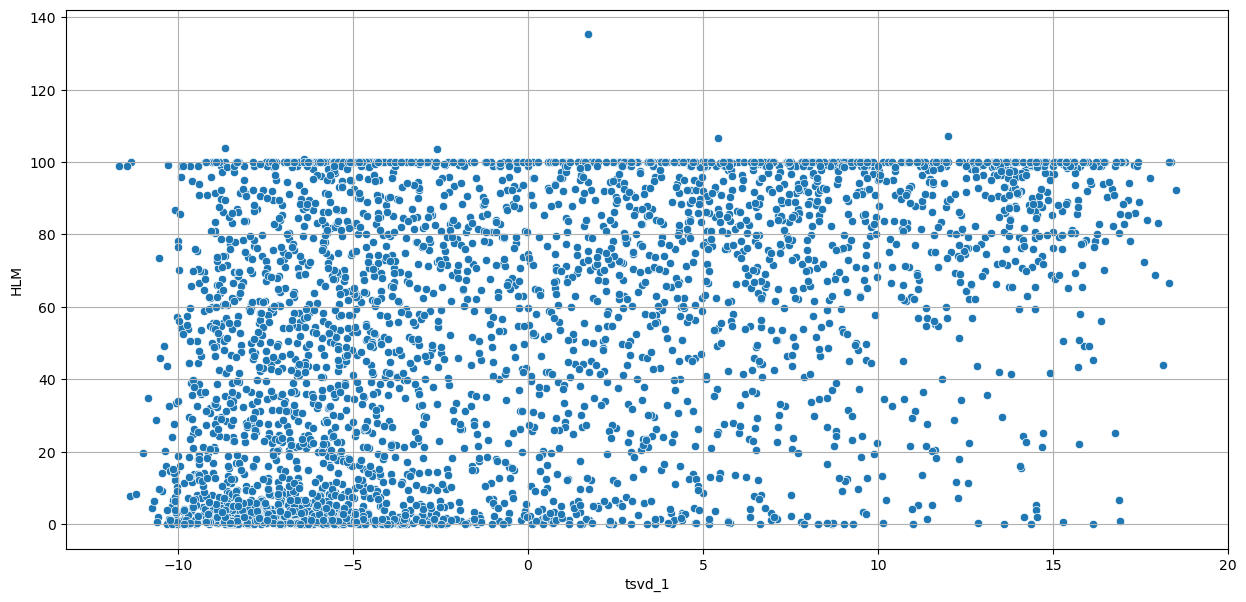

In [83]:
plt.figure(figsize=(15,7))
sns.scatterplot(x=train_df['tsvd_1'],y=train_df['HLM'])
plt.grid()
plt.show()

<br>

## Memory Reduce

In [84]:
# train_df, _ = reduce_mem_usage(train_df,verbose=False)
# test_df , _ = reduce_mem_usage(test_df ,verbose=False)

In [85]:
train_df.to_parquet('./out/train_df.parquet')
test_df .to_parquet('./out/test_df.parquet')

<br></br>

# Modeling

In [86]:
import numpy as np
def multi_rmse(y_true,y_pred):
    y_true = np.array(y_true)
    y_pred = np.array(y_pred)
    
    rmse_list = []
    for i in range(y_true.shape[1]):
        rmse = mean_squared_error(y_true=y_true[:,i],y_pred=y_pred[:,i])**0.5
        rmse_list.append(rmse)
    
    return np.mean(rmse_list)

In [87]:
import pandas as pd
train_fn = pd.read_parquet('./out/train_df.parquet')
test_fn  = pd.read_parquet('./out/test_df.parquet')

In [88]:
X        = train_fn.drop(CFG.TARGET,axis=1)
X_submit = test_fn.copy()

ohe = OneHotEncoder()
ohe.fit(X,cat_features,remove_first=True)
X = ohe.transform(X)
X_submit = ohe.transform(X_submit)

y = train_fn[CFG.TARGET]

# unique인 컬럼 제외
unique_info = X.nunique()
unique_cols = unique_info[unique_info==1].index.tolist()
if len(unique_cols)>0:
    X.drop(unique_cols,axis=1,inplace=True)
    X_submit.drop(unique_cols,axis=1,inplace=True)
    print('deleted:',len(unique_cols))

In [89]:
X.head()

,tsvd_1,tsvd_2,tsvd_3,tsvd_4,tsvd_5,tsvd_6,tsvd_7,tsvd_8,tsvd_9,tsvd_10,tsvd_11,tsvd_12,tsvd_13,tsvd_14,tsvd_15,tsvd_16,tsvd_17,tsvd_18,tsvd_19,tsvd_20,tsvd_21,tsvd_22,tsvd_23,tsvd_24,tsvd_25,tsvd_26,tsvd_27,tsvd_28,tsvd_29,tsvd_30,tsvd_31,tsvd_32,tsvd_33,tsvd_34,tsvd_35,tsvd_36,tsvd_37,tsvd_38,tsvd_39,tsvd_40,tsvd_41,tsvd_42,tsvd_43,tsvd_44,tsvd_45,tsvd_46,tsvd_47,tsvd_48,tsvd_49,tsvd_50,tsvd_51,tsvd_52,tsvd_53,tsvd_54,tsvd_55,tsvd_56,tsvd_57,tsvd_58,tsvd_59,tsvd_60,tsvd_61,tsvd_62,tsvd_63,tsvd_64,AlogP_quantile11_grp_1,AlogP_quantile11_grp_2,AlogP_quantile11_grp_3,AlogP_quantile11_grp_4,AlogP_quantile11_grp_5,AlogP_quantile11_grp_6,AlogP_quantile11_grp_7,AlogP_quantile11_grp_8,AlogP_quantile11_grp_9,Molecular_Weight_quantile11_grp_1,Molecular_Weight_quantile11_grp_2,Molecular_Weight_quantile11_grp_3,Molecular_Weight_quantile11_grp_4,Molecular_Weight_quantile11_grp_5,Molecular_Weight_quantile11_grp_6,Molecular_Weight_quantile11_grp_7,Molecular_Weight_quantile11_grp_8,Molecular_Weight_quantile11_grp_9,LogD_quantile11_grp_1,LogD_quantile11_grp_2,LogD_quantile11_grp_3,LogD_quantile11_grp_4,LogD_quantile11_grp_5,LogD_quantile11_grp_6,LogD_quantile11_grp_7,LogD_quantile11_grp_8,LogD_quantile11_grp_9,Molecular_PolarSurfaceArea_quantile11_grp_1,Molecular_PolarSurfaceArea_quantile11_grp_2,Molecular_PolarSurfaceArea_quantile11_grp_3,Molecular_PolarSurfaceArea_quantile11_grp_4,Molecular_PolarSurfaceArea_quantile11_grp_5,Molecular_PolarSurfaceArea_quantile11_grp_6,Molecular_PolarSurfaceArea_quantile11_grp_7,Molecular_PolarSurfaceArea_quantile11_grp_8,Molecular_PolarSurfaceArea_quantile11_grp_9,Num_H_Acceptors_1,Num_H_Acceptors_10,Num_H_Acceptors_11,Num_H_Acceptors_12,Num_H_Acceptors_13,Num_H_Acceptors_15,Num_H_Acceptors_2,Num_H_Acceptors_3,Num_H_Acceptors_4,Num_H_Acceptors_5,Num_H_Acceptors_6,Num_H_Acceptors_7,Num_H_Acceptors_8,Num_H_Acceptors_9,Num_H_Donors_1,Num_H_Donors_10,Num_H_Donors_2,Num_H_Donors_3,Num_H_Donors_4,Num_H_Donors_5,Num_H_Donors_6,Num_H_Donors_7,Num_H_Donors_8
0,-1.389730,4.858104,6.121495,-1.086803,-2.872214,0.132927,1.943974,-0.603370,-3.319855,-2.710493,0.242087,-1.892980,3.200623,1.190837,-0.099246,1.141411,-1.955663,0.665338,-0.235281,2.110513,-0.667280,-1.478668,0.531282,2.901868,-0.398301,-2.439619,-0.971251,1.957692,-2.558427,0.966033,1.771513,-2.357971,-2.259253,0.250963,-2.478512,2.001135,1.975200,1.018598,0.924156,-0.400260,2.522317,-3.448137,-0.920313,1.058803,-1.267273,-1.532495,2.672931,-0.445246,-0.173341,-0.290359,2.184592,1.293949,-1.741614,-0.278025,-1.131856,-1.422993,0.815878,-0.611302,-0.160905,1.918453,1.115439,-0.822123,-0.707912,-0.414943,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0
1,2.141187,-6.699122,-0.167448,-0.393493,-1.379890,-3.399933,0.343495,-2.979756,0.289426,-0.675393,2.487077,0.448898,-0.124198,1.148677,-0.612920,-0.412585,-0.455305,-1.199968,-0.795156,1.846927,-0.410495,-0.695595,0.972355,-0.484913,0.910142,0.154565,-0.852969,-0.150419,-0.404789,1.779107,0.196560,-0.783095,-1.513440,-1.097639,0.117571,-0.260292,-0.138477,-1.017685,0.326143,-0.329997,2.071030,-0.235031,-0.221029,-0.573237,0.077983,0.408971,-1.854596,0.475375,-1.063333,0.907577,0.352605,1.340370,0.938101,1.518529,-1.231322,0.986670,2.212305,-0.450407,0.218472,-0.162560,0.671573,-0.037990,-0.708364,0.118672,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0
2,4.328761,-0.872288,-4.916591,-3.360874,3.915855,3.760873,-3.036942,3.551876,-2.111702,-2.220076,-0.518242,-1.972992,-3.247601,0.869506,0.672077,0.721505,-0.848271,0.315722,0.397441,2.852516,-1.698001,-0.974739,2.151788,2.620174,-1.145413,2.682764,-2.231771,-0.230730,-1.234731,-4.690670,-0.761080,0.390939,-1.533995,-0.078342,1.603830,2.269079,0.385011,2.858337,-0.952319,1.434762,2.417300,-0.022304,-0.362950,0.604287,0.941233,2.979534,0.361323,0.217619,0.138970,1.411202,1.520031,-2.393311,-1.698028,1.802203,0.433619,-0.619732,

In [90]:
X.shape

(3498, 123)

<br>

## autogluon

In [ ]:
# !pip install autogluon

In [ ]:
import pandas as pd
from autogluon.tabular import TabularDataset, TabularPredictor

# 데이터 로드
train_data = TabularDataset('./out/train_df.parquet')
test_data  = TabularDataset('./out/test_df.parquet')

# 모델의 평가 지표 및 시간 설정
eval_metrics = ['root_mean_squared_error', 'mean_absolute_error', 'r2']
time_limits = [5400, 5400, 5400]
model_paths = ['AutogluonModels/model_rmse_1h30m', 'AutogluonModels/model_mae_1h30m', 'AutogluonModels/model_r2_1h30m']

In [ ]:
all_predictions = []

# 각 평가 지표로 모델 훈련 및 예측
for i, (eval_metric, time_limit, save_path) in enumerate(zip(eval_metrics, time_limits, model_paths)):
    predictor = TabularPredictor(
        label='critical_temp',
        path=save_path,
        eval_metric=eval_metric
    ).fit(
        train_data=train_data,
        presets='best_quality',
        time_limit=time_limit
    )

    test_pred = predictor.predict(test_data)
    all_predictions.append(test_pred)

    # submission 파일 저장
    submission = pd.read_csv('sample_submission.csv')
    submission['critical_temp'] = test_pred
    submission.to_csv(f'./autogluon_model_{eval_metric}_1h30m_submit.csv', index=False)

<br>

## mljar-supervised
- 참조 : [공식문서](https://supervised.mljar.com/features/modes/), [Dacon](https://dacon.io/competitions/official/236146/codeshare/8700?page=1&dtype=recent)

In [91]:
# !pip install --upgrade pip
# !pip install --user mljar-supervised

In [92]:
from supervised.automl import AutoML
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
import datetime

Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)


In [93]:
import random, os
import numpy as np
def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)

seed_everything(CFG.SEED) # Seed 고정

In [94]:
def rmse(y_true,y_pred):
    return mean_squared_error(y_true=y_true,y_pred=y_pred)**0.5

In [95]:
import warnings
warnings.filterwarnings("ignore", category=UserWarning)

In [96]:
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2,shuffle=True,random_state=CFG.SEED)

In [101]:
%%time

mode = "Perform" # "Explain","Perform","Compete",
log = pd.DataFrame(index=[0])

goodness_of_fit_list = []
automl_list = []
for iter,target in enumerate(CFG.TARGET):
    print('-'*100)
    print('> [{}/{}] {}'.format(iter+1,len(CFG.TARGET),target))
    print('-'*100)
    validation_strategy = {
        "validation_type": "kfold",
        "k_folds": 5,
        "shuffle": True,
        "stratify": False,
        "random_seed": CFG.SEED,
    }
    
    results_paths = './mc/automl_ncomp{}_{}_{}/'.format(n_components,mode,target)
    automl = AutoML(
        results_path = results_paths,
        mode = mode,
        algorithms = ['Random Forest', 'LightGBM', 'Xgboost', 'CatBoost'],
        ml_task = "regression", eval_metric = 'rmse',
        validation_strategy = validation_strategy,
        random_state = CFG.SEED, total_time_limit=43200,
    )

    log[f'{target}_starttime'] = datetime.datetime.now() + datetime.timedelta(hours=9)
    log.to_csv('./log_ncomp{}_{}_{}.csv'.format(n_components,mode,target),index=False)
    
    automl.fit(X_train, y_train[target])
    goodness_of_fit = automl.score(X_test,y_test[target])
    
    automl_list.append(automl)
    goodness_of_fit_list.append(goodness_of_fit)
    
    log[f'{target}_endtime'] = datetime.datetime.now() + datetime.timedelta(hours=9)
    log.to_csv('./log_ncomp{}_{}_{}.csv'.format(n_components,mode,target),index=False)

----------------------------------------------------------------------------------------------------
> [1/2] MLM
----------------------------------------------------------------------------------------------------
AutoML directory: ./mc/automl_ncomp64_Perform_MLM/
The task is regression with evaluation metric rmse
AutoML will use algorithms: ['Random Forest', 'LightGBM', 'Xgboost', 'CatBoost']
AutoML will ensemble available models
AutoML steps: ['simple_algorithms', 'default_algorithms', 'not_so_random', 'golden_features', 'insert_random_feature', 'features_selection', 'hill_climbing_1', 'hill_climbing_2', 'ensemble']
Skip simple_algorithms because no parameters were generated.
* Step default_algorithms will try to check up to 4 models
1_Default_LightGBM rmse 30.917202999999997 trained in 28.28 seconds (1-sample predict time 0.1756 seconds)
2_Default_Xgboost rmse 30.740495 trained in 19.01 seconds (1-sample predict time 0.1776 seconds)
3_Default_CatBoost rmse 30.676007 trained in 26.52

/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less


AutoML fit time: 1436.0 seconds
AutoML best model: 3_Default_CatBoost_GoldenFeatures_SelectedFeatures
----------------------------------------------------------------------------------------------------
> [2/2] HLM
----------------------------------------------------------------------------------------------------
AutoML directory: ./mc/automl_ncomp64_Perform_HLM/
The task is regression with evaluation metric rmse
AutoML will use algorithms: ['Random Forest', 'LightGBM', 'Xgboost', 'CatBoost']
AutoML will ensemble available models
AutoML steps: ['simple_algorithms', 'default_algorithms', 'not_so_random', 'golden_features', 'insert_random_feature', 'features_selection', 'hill_climbing_1', 'hill_climbing_2', 'ensemble']
Skip simple_algorithms because no parameters were generated.
* Step default_algorithms will try to check up to 4 models
1_Default_LightGBM rmse 36.633022 trained in 33.46 seconds (1-sample predict time 0.3408 seconds)
2_Default_Xgboost rmse 36.243358 trained in 25.95 seco

/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less


AutoML fit time: 2387.73 seconds
AutoML best model: 35_CatBoost_GoldenFeatures
CPU times: user 2h 44min 59s, sys: 42min, total: 3h 27min
Wall time: 1h 3min 44s


In [102]:
def automl_predict(automls,X):
    preds = []
    for automl in automl_list:
        pred = automl.predict_all(X)['prediction'].values
        preds.append(pred)
    preds = np.stack(preds).T
    return preds

In [103]:
tr_pred = automl_predict(automl_list,X_train)
te_pred = automl_predict(automl_list,X_test)
tr_true = np.array(y_train)
te_true = np.array(y_test)

In [104]:
# score
multi_rmse(y_true=tr_true,y_pred=tr_pred),multi_rmse(y_true=te_true,y_pred=te_pred)

(21.910002595405196, 31.563566635521582)

1. Explain
    - tsvd 32 : 33.231205120268285 (4.5m)
    - tsvd 64 : 33.127090417520975
    - tsvd 128 : 33.188490579241716
    - no tsvd : 33.10018966417917 (19m)
2. Perform
    - tsvd 32 : 31.91612346823355 (38m)
    - tsvd 64 : 31.563566635521582 (63m)
3. Complete
    - tsvd 32 : 31.769374492978923 (71m)

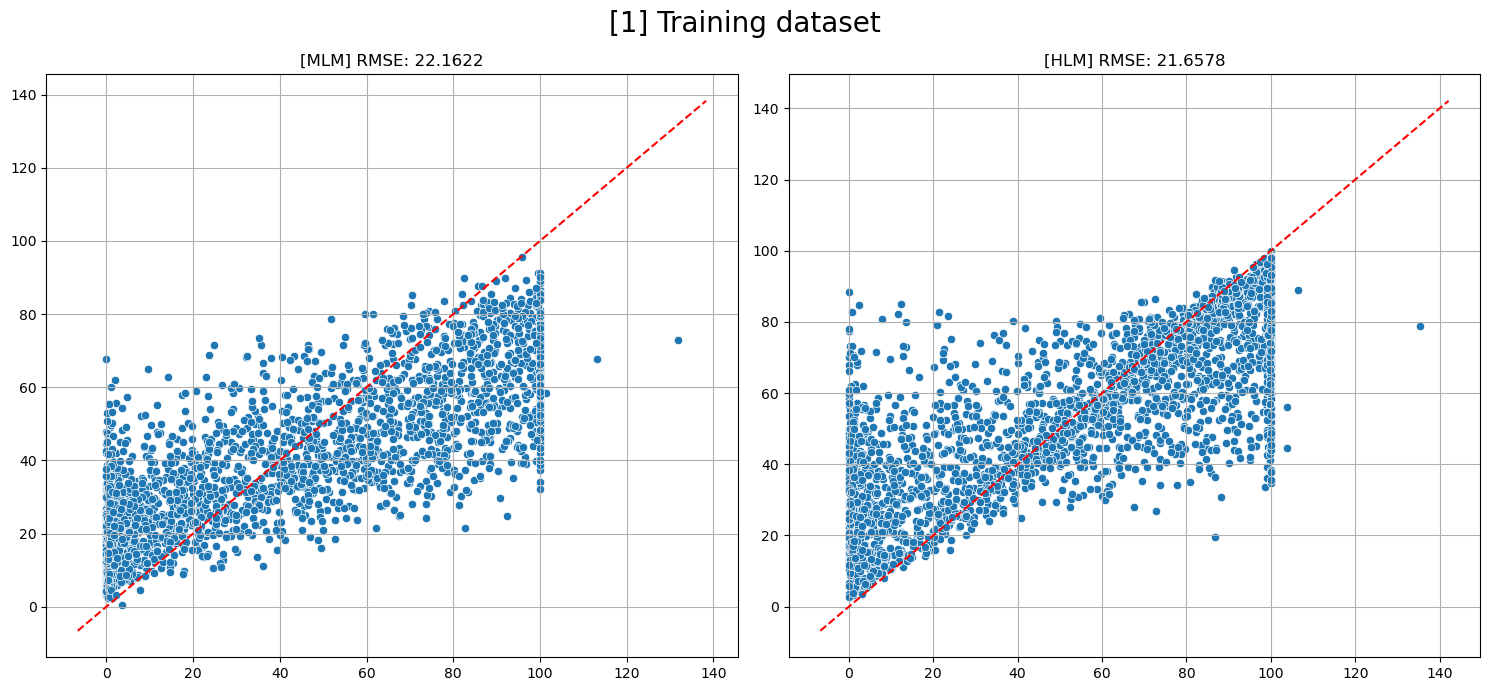

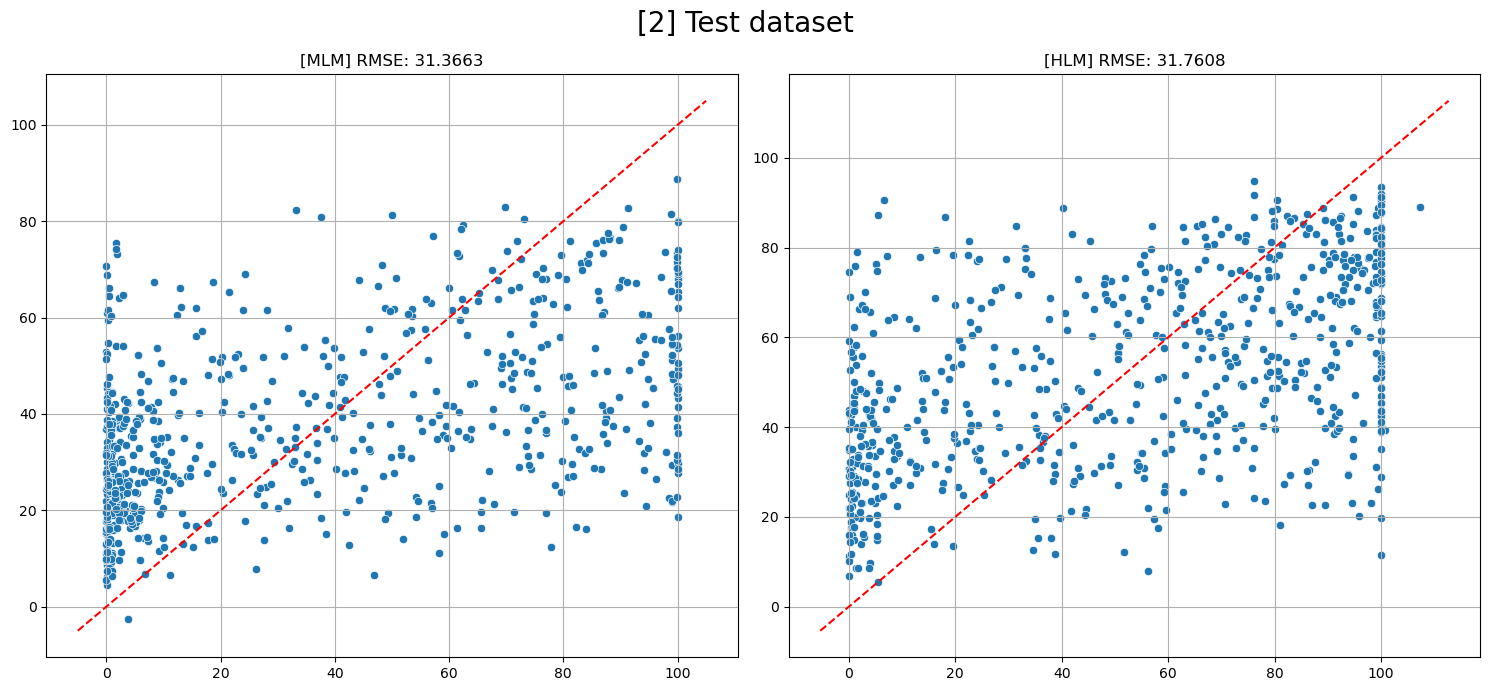

In [105]:
tr_mlm_rmse = mean_squared_error(y_true=tr_true[:,0],y_pred=tr_pred[:,0])**0.5
tr_hlm_rmse = mean_squared_error(y_true=tr_true[:,1],y_pred=tr_pred[:,1])**0.5
te_mlm_rmse = mean_squared_error(y_true=te_true[:,0],y_pred=te_pred[:,0])**0.5
te_hlm_rmse = mean_squared_error(y_true=te_true[:,1],y_pred=te_pred[:,1])**0.5

# train
fig = plt.figure(figsize=(15,7))
fig.add_subplot(121)
sns.scatterplot(x=tr_true[:,0],y=tr_pred[:,0])
abline(0,1)
plt.grid()
plt.title('[{}] RMSE: {:.4f}'.format(CFG.TARGET[0],tr_mlm_rmse))
fig.add_subplot(122)
sns.scatterplot(x=tr_true[:,1],y=tr_pred[:,1])
abline(0,1)
plt.grid()
plt.title('[{}] RMSE: {:.4f}'.format(CFG.TARGET[1],tr_hlm_rmse))
plt.suptitle('[1] Training dataset',fontsize=20)
plt.tight_layout()
plt.show()

# validation
fig = plt.figure(figsize=(15,7))
fig.add_subplot(121)
sns.scatterplot(x=te_true[:,0],y=te_pred[:,0])
abline(0,1)
plt.grid()
plt.title('[{}] RMSE: {:.4f}'.format(CFG.TARGET[0],te_mlm_rmse))
fig.add_subplot(122)
sns.scatterplot(x=te_true[:,1],y=te_pred[:,1])
abline(0,1)
plt.grid()
plt.title('[{}] RMSE: {:.4f}'.format(CFG.TARGET[1],te_hlm_rmse))
plt.suptitle('[2] Test dataset',fontsize=20)
plt.tight_layout()
plt.show()

<br></br>

# Inference

In [106]:
submit_pred = automl_predict(automl_list,X_submit)

In [107]:
submit = pd.read_csv('./data/sample_submission.csv')
submit[CFG.TARGET] = submit_pred

In [108]:
submit.head()

,id,MLM,HLM
0,TEST_000,39.634908,64.922230
1,TEST_001,50.851379,59.074503
2,TEST_002,43.998702,62.350357
3,TEST_003,29.557007,61.634787
4,TEST_004,54.938057,74.000189


In [109]:
# public :  (identity)
submit.to_csv('./out/mljar_supervised_automl_ncomp{}_{}.csv'.format(n_components,mode),index=False)